В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [1]:
import os
from pathlib import Path
from typing import Tuple, Dict, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import xgboost as xgb
import lightgbm as lgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials


In [2]:
def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

In [3]:
data_path = Path(r'C:\Users\olha.koltun\OneDrive - Trico\ML Course\data\bank-customer-churn-prediction-dlu-course-c-2')
raw_df = pd.read_csv(data_path / 'train.csv')

target_col = 'Exited'
input_cols = raw_df.drop(columns=[target_col]).columns[3:]

# Split dataset
train_df, val_df = split_train_val(raw_df, target_col)

# Separate inputs and targets
train_inputs, train_targets = separate_inputs_targets(train_df, input_cols, target_col)
val_inputs, val_targets = separate_inputs_targets(val_df, input_cols, target_col)

1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [4]:
cat_features = train_inputs.select_dtypes(include='object').columns
train_inputs[cat_features] = train_inputs[cat_features].astype('category')
val_inputs[cat_features] = val_inputs[cat_features].astype('category')

cat_feature_indexes = [train_inputs.columns.get_loc(col) for col in cat_features]

2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [5]:
def compute_auroc(model, train_inputs, train_targets, val_inputs, val_targets):
    """
    Computes Train & Validation AUROC for a given model.

    Parameters:
    - model: Trained classifier (XGBoost or LightGBM).
    - train_inputs: Features for training.
    - train_targets: Target labels for training.
    - val_inputs: Features for validation.
    - val_targets: Target labels for validation.

    Returns:
    - Dictionary with 'Train AUROC' and 'Validation AUROC' scores.
    """
    # Get predictions
    train_pred = model.predict_proba(train_inputs)[:, 1]
    val_pred = model.predict_proba(val_inputs)[:, 1]

    # Compute AUROC
    train_auroc = roc_auc_score(train_targets, train_pred)
    val_auroc = roc_auc_score(val_targets, val_pred)

    # Print results
    print(f'Train AUROC: {train_auroc:.4f}, Validation AUROC: {val_auroc:.4f}')

    # Return AUROC results as a dictionary
    return {'Train AUROC': train_auroc, 'Validation AUROC': val_auroc}

# Initialize dictionary to store results
auroc_results = {}

In [6]:
xgb_clf = xgb.XGBClassifier(
    max_depth=3,
    n_estimators=10,
    enable_categorical=True,  
    use_label_encoder=False,  
    missing=np.nan,  
    #device='cuda'
)

xgb_clf.fit(train_inputs, train_targets)

# Compute AUROC and store results
auroc_results['XGBoostClf'] = compute_auroc(
    xgb_clf, train_inputs, train_targets, val_inputs, val_targets
)

Train AUROC: 0.9344, Validation AUROC: 0.9334


C:\Users\olha.koltun\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:26:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


### **Висновок про модель XGBoost:**
- Модель хороша – `Train AUROC = 0.9344`, `Validation AUROC = 0.9334`.
- Низький bias, низький variance – різниця між train і validation мінімальна (~0.001).
- Немає ознак overfitting або underfitting.

### **Порівняння з DecisionTrees використаним раніше:**
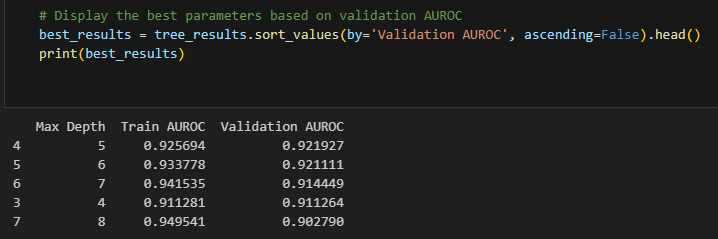

`XGBoost` перевершує `DecisionTree` з `Validation AUROC`, вищим за найкращий результат `DecisionTree` (**0.9219**).

3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [7]:
def objective(params):
    clf = xgb.XGBClassifier(
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],  
        subsample=params['subsample'], 
        colsample_bytree=params['colsample_bytree'], 
        gamma=params['gamma'], 
        reg_alpha=params['reg_alpha'],  
        reg_lambda=params['reg_lambda'], 
        enable_categorical=True,
        use_label_encoder=False,
        missing=np.nan,
        #device='cuda',
        early_stopping_rounds=10
    )

    clf.fit(
        train_inputs,
        train_targets,
        eval_set=[(val_inputs, val_targets)],
        verbose=False)
    
    pred = clf.predict_proba(val_inputs)[:, 1]
    auroc = roc_auc_score(val_targets, pred)

    return {'loss': -auroc, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf = xgb.XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    enable_categorical=True,
    use_label_encoder=False,
    missing=np.nan,
    #device='cuda',
    early_stopping_rounds=10
)

final_clf.fit(
    train_inputs, 
    train_targets,
    eval_set=[(val_inputs, val_targets)],
    verbose=False
)

# Compute AUROC and store results
auroc_results['XGBoostClf+Hyperopt'] = compute_auroc(
    final_clf, train_inputs, train_targets, val_inputs, val_targets
)

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

C:\Users\olha.koltun\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:28:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\olha.koltun\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:28:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 15%|█▌        | 3/20 [00:00<00:02,  7.40trial/s, best loss: -0.9367453186089582]

C:\Users\olha.koltun\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:28:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\olha.koltun\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:28:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 30%|███       | 6/20 [00:00<00:01,  8.67trial/s, best loss: -0.9367453186089582]

C:\Users\olha.koltun\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:28:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\olha.koltun\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:28:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 35%|███▌      | 7/20 [00:00<00:01,  8.16trial/s, best loss: -0.9367453186089582]

C:\Users\olha.koltun\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:28:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\olha.koltun\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:28:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 45%|████▌     | 9/20 [00:01<00:01,  8.66trial/s, best loss: -0.9367453186089582]

C:\Users\olha.koltun\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:28:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\olha.koltun\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:28:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 60%|██████    | 12/20 [00:01<00:00,  8.66trial/s, best loss: -0.9367453186089582]

C:\Users\olha.koltun\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:28:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\olha.koltun\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:28:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\olha.koltun\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:28:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

 

 65%|██████▌   | 13/20 [00:01<00:00,  8.67trial/s, best loss: -0.9367453186089582]

C:\Users\olha.koltun\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:28:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\olha.koltun\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:28:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 85%|████████▌ | 17/20 [00:02<00:00,  8.60trial/s, best loss: -0.9367453186089582]

C:\Users\olha.koltun\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:28:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\olha.koltun\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:28:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\olha.koltun\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:28:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

 

 95%|█████████▌| 19/20 [00:02<00:00,  9.05trial/s, best loss: -0.9367453186089582]

C:\Users\olha.koltun\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:28:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\olha.koltun\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:28:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



100%|██████████| 20/20 [00:02<00:00,  8.34trial/s, best loss: -0.9367453186089582]
Найкращі гіперпараметри:  {'colsample_bytree': 0.6415750144192909, 'gamma': 0.02621204781658243, 'learning_rate': 0.06166124891159406, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 175, 'reg_alpha': 0.17698043640534467, 'reg_lambda': 0.6648752859858549, 'subsample': 0.5534347024375561}
Train AUROC: 0.9468, Validation AUROC: 0.9367


C:\Users\olha.koltun\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:28:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


### **Висновок:**
- Модель покращилася:
    - `Train AUROC`: **0.9344 → 0.9468**
    - `Validation AUROC`: **0.9334 → 0.9367**
- `Validation AUROC` зріс, різниця між `train` і `validation` мінімальна → без overfitting.
- `Hyperopt` дав кращі гіперпараметри, що підвищило якість моделі.

4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [8]:
lgb_clf = lgb.LGBMClassifier(
    max_depth=3,
    n_estimators=50,
    learning_rate=0.1,
    cat_feature=cat_feature_indexes,  
    missing=np.nan,  
    # device='cuda'  # використовувати GPU для прискорення обчислень
)

lgb_clf.fit(
    train_inputs, 
    train_targets, 
    eval_set=[(val_inputs, val_targets)]
)

# Compute AUROC and store results
auroc_results['LightGBMClf'] = compute_auroc(
    lgb_clf, train_inputs, train_targets, val_inputs, val_targets
)

[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] categorical_feature is set with categorical_column=1,2, will be overridden by cat_feature=1,2. Current value: categorical_feature=1,2
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

### **Висновок про якість моделі (LightGBM):**
- `Train AUROC`: **0.9388**
- `Validation AUROC`: **0.9362**
- Модель добре узагальнює дані – різниця між `train` і `validation` мінімальна.
- Немає *high bias* або *high variance*, оскільки показники стабільні.

### **Порівняння з XGBoost та XGBoost + Hyperopt:**
- `LightGBM` перевершує `XGBoost` (базовий) → `Validation AUROC` зріс (**0.9334 → 0.9362**).
- `XGBoost + Hyperopt` все ще трохи кращий (**0.9367**), але різниця мінімальна.

5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [9]:
def objective(params):
    clf = lgb.LGBMClassifier(
        n_estimators=int(params['n_estimators']),  # Кількість дерев у ансамблі (кількість ітерацій бустингу)
        learning_rate=params['learning_rate'],  # Коефіцієнт, на який зменшується внесок кожного доданого дерева
        max_depth=int(params['max_depth']),  # Максимальна глибина кожного дерева
        num_leaves=int(params['num_leaves']),  # Максимальна кількість листків, що дозволяємо кожному дереву мати.
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        min_split_gain=params['min_split_gain'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        cat_feature=cat_feature_indexes  # Індекси категорійних ознак
    )

    clf.fit(
        train_inputs, 
        train_targets, 
        eval_set=[(val_inputs, val_targets)]
    )

    pred = clf.predict_proba(val_inputs)[:, 1]
    auroc = roc_auc_score(val_targets, pred)

    return {'loss': -auroc, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.1)  # додано мінімальне зменшення втрат для поділу
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['num_leaves'] = int(best['num_leaves'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_lgb_clf = lgb.LGBMClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    num_leaves=best['num_leaves'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    min_split_gain=best['min_split_gain'],
    cat_feature=cat_feature_indexes,
    missing=np.nan
)

final_lgb_clf.fit(
    train_inputs, 
    train_targets, 
    eval_set=[(val_inputs, val_targets)]
)

# Compute AUROC and store results
auroc_results['LightGBMClf+Hyperopt'] = compute_auroc(
    final_lgb_clf, train_inputs, train_targets, val_inputs, val_targets
)

[LightGBM] [Warning] categorical_feature is set with categorical_column=1,2, will be overridden by cat_feature=1,2. Current value: categorical_feature=1,2
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 843                      
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561 
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

### **Висновок про якість моделі (LightGBM + Hyperopt):**
- `Validation AUROC` майже не змінився (з **0.9362 → 0.9364**), що означає мінімальне покращення узагальнюючої здатності.
- Ризик перенавчання зріс, оскільки розрив між `Train` та `Validation AUROC` збільшився (з 0.0026 до 0.0120).

6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

In [10]:
# Convert AUROC results dictionary to a DataFrame
auroc_df = pd.DataFrame.from_dict(auroc_results, orient='index').sort_values(by="Validation AUROC", ascending=False)

auroc_df

,Train AUROC,Validation AUROC
XGBoostClf+Hyperopt,0.946824,0.936745
LightGBMClf+Hyperopt,0.948379,0.936378
LightGBMClf,0.938808,0.936223
XGBoostClf,0.934431,0.933417


### **Обрана модель: `XGBoostClf+Hyperopt`**  
- `XGBoostClf+Hyperopt` має найкращий баланс між навчанням та узагальненням
- `Validation AUROC` = **0.9367** (найвищий або майже рівний іншим моделям).  
- `Train AUROC` = **0.9468**, що нижче, ніж у `LightGBMClf+Hyperopt` (**0.9484**), але має **менший розрив між Train і Validation**, що вказує на **менше перенавчання**.  

`LightGBMClf+Hyperopt` має трохи вищий `Train AUROC`, але `Validation AUROC` трохи нижчий, що може вказувати на **легке перенавчання**.  

**XGBoostClf+Hyperopt демонструє найкращу узагальнюючу здатність, що робить його оптимальним вибором!**

In [11]:
new_data = pd.read_csv(data_path / 'test.csv')
new_data = new_data.drop(columns=['CustomerId', 'Surname'])

# Select input columns (excluding 'id' if present)
new_input_cols = [col for col in new_data.columns if col != 'id']

# Convert categorical features to category dtype
cat_features = new_data.select_dtypes(include='object').columns
new_data[cat_features] = new_data[cat_features].astype('category')

# Predict probabilities using the trained model
new_data['Exited'] = final_lgb_clf.predict_proba(new_data[new_input_cols])[:, 1]

new_data.head()

[LightGBM] [Warning] Unknown parameter: missing


,id,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15000,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86,0.095452
1,15001,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28,0.016530
2,15002,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45,0.051799
3,15003,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87,0.518251
4,15004,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97,0.033975


In [12]:
submission_df = pd.read_csv(data_path / 'sample_submission.csv')

submission_df['Exited'] = new_data.set_index('id').loc[submission_df['id'], 'Exited'].values

print('First 5 rows of the submission file:')
print(submission_df.head())

submission_df.to_csv(os.path.join(data_path, 'submission_log_reg.csv'), index=False)
print('Submission file saved as submission_log_reg.csv. Ready for upload to Kaggle!')


First 5 rows of the submission file:
      id    Exited
0  15000  0.095452
1  15001  0.016530
2  15002  0.051799
3  15003  0.518251
4  15004  0.033975
Submission file saved as submission_log_reg.csv. Ready for upload to Kaggle!


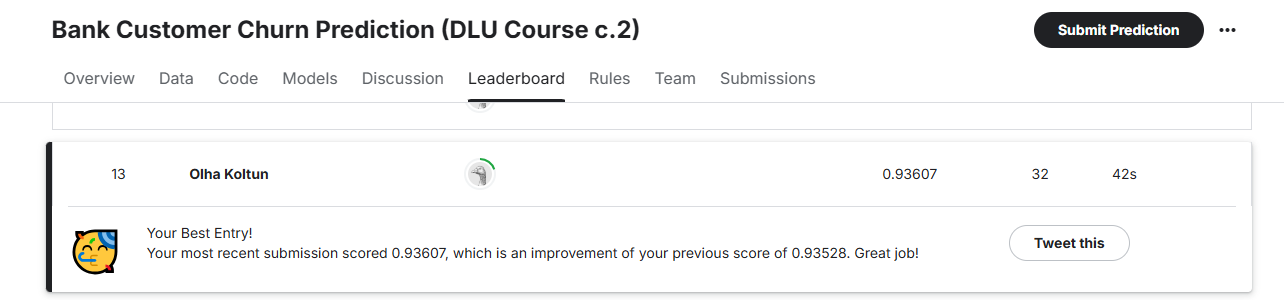

### Аналіз найкращих моделей: що спрацювало і чому?
Окрім `XGBoostClassifier` та `LightGBMClassifier` з тюнінгом гіперпараметрів, хороші результати також показала **логістична регресія з балансуванням класів** (`Random Oversampling`, `TomekLinks`) та поліноміальними ознаками.

**Логістична регресія** добре спрацювала завдяки комбінації балансування вибірки та розширення ознак.
- `Random Oversampling` компенсує дисбаланс класів, створюючи додаткові зразки для менш представленого класу.
- `TomekLinks` очищає вибірку, видаляючи менш інформативні зразки, що зменшує шум у даних.
- Поліноміальні ознаки допомагають вловити складні нелінійні взаємозв’язки, що значно покращує можливості регресії.

Завдяки цим методам **логістична регресія** навчилася ефективніше працювати з дисбалансом та складними взаємозв’язками в даних.

**Градієнтний бустинг** забезпечує високу якість передбачень завдяки ансамблю дерев, які ефективно знаходять нелінійні закономірності.

**Hyperopt** значно покращив підбір гіперпараметрів. Байєсівська оптимізація допомогла мінімізувати перенавчання, знаходячи оптимальне поєднання параметрів, що покращило продуктивність моделей.